## MNIST VAE Demo


In [1]:
# based on examples from https://github.com/pytorch/examples
# https://github.com/L1aoXingyu/pytorch-beginner/https://github.com/L1aoXingyu/pytorch-beginner/
# https://github.com/bfarzin/pytorch_aae/blob/master/main_aae.py
# https://github.com/artemsavkin/aae/blob/master/aae.ipynb
import argparse
import os
import torch
import time
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
import torch.distributions as D

In [3]:
def save_reconstructs(model, x, epoch):
        with torch.no_grad():
            x = x.to(device)
            sample, _, __ = model(x)
            save_image(x.view(x.shape[0], 1, 28, 28),
                       'results/originals_' + str(epoch) + '.png')
            save_image(sample.view(x.shape[0], 1, 28, 28),
                       'results/reconstructs_' + str(epoch) + '.png')

def save_random_reconstructs(model, nz, epoch):
        with torch.no_grad():
            sample = torch.randn(64, nz).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'results/sample_' + str(epoch) + '.png')

class VAE(nn.Module):
    def __init__(self, nin, nz, nh1, nh2, nh3, nh4):
        super(VAE, self).__init__()

        self.nin = nin
        self.nz = nz

        self.encoder = nn.Sequential(
                nn.Linear(nin, nh1), 
                nn.ReLU(),
                nn.Linear(nh1, nh2),
                nn.ReLU(),
                )

        self.decoder = nn.Sequential(
                nn.Linear(nz, nh3),
                nn.ReLU(),
                nn.Linear(nh2, nh4),
                nn.ReLU(),
                nn.Linear(nh4, nin),
                nn.Sigmoid()
                )

        self.mumap = nn.Linear(nh2, nz)
        self.logvarmap = nn.Linear(nh2, nz)

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mumap(h)
        logvar = self.logvarmap(h)
        return mu, logvar
        #h1 = F.relu(self.fc1(x))
        #return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        x = self.decoder(z)
        return x
        #h3 = F.relu(self.fc3(z))
        #return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = x.view(-1, self.nin)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [4]:
# parameters
nin = 28*28
nz = 20
batchSize = 256
epochs = 20

device = "cuda" if torch.cuda.is_available() else "cpu"



train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../data", train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=batchSize,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("../data", train=False, transform=transforms.ToTensor()),
    batch_size=batchSize,
    shuffle=True,
)

bce = nn.BCELoss(reduction="sum")
kld = lambda mu, logvar : -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

#model = VAE(nin, nz, 2*1024, 2*512, 2*512, 2*1024).to(device)
model = VAE(nin, nz, 2*1024, 2*512, 2*512, 2*1024).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)


In [5]:
# training
for epoch in range(epochs):
    for idx, (data, _) in enumerate(train_loader):
        batch_size = data.shape[0]
        x = data.view(-1,nin).to(device)
        model.train()
        model.requires_grad_(True)
        optimizer.zero_grad()
        recon, mu, logvar = model(x)
        loss_recon = bce(recon, x)
        loss_kld = kld(mu, logvar)
        #loss_recon.backward()
        #loss_kld.backward()
        loss = loss_kld + loss_recon
        loss.backward()
        optimizer.step()
        if idx % 5000 == 0:
            print("losses:\n",
                    "reconstruction loss:", loss_recon.item(),
                    "kld:", loss_kld.item()
                    )



losses:
 reconstruction loss: 139379.703125 kld: 5.054736137390137
losses:
 reconstruction loss: 38205.04296875 kld: 2803.38671875
losses:
 reconstruction loss: 28497.1328125 kld: 4108.572265625
losses:
 reconstruction loss: 24236.71484375 kld: 4709.1474609375
losses:
 reconstruction loss: 23718.6875 kld: 5008.68505859375
losses:
 reconstruction loss: 21993.92578125 kld: 5287.1103515625
losses:
 reconstruction loss: 22020.4765625 kld: 5392.91259765625
losses:
 reconstruction loss: 21303.046875 kld: 5397.08642578125
losses:
 reconstruction loss: 21219.671875 kld: 5335.0146484375
losses:
 reconstruction loss: 20572.05078125 kld: 5444.87939453125
losses:
 reconstruction loss: 20380.125 kld: 5410.6025390625
losses:
 reconstruction loss: 20086.97265625 kld: 5530.3671875
losses:
 reconstruction loss: 20292.158203125 kld: 5530.6572265625
losses:
 reconstruction loss: 20848.0546875 kld: 5555.177734375
losses:
 reconstruction loss: 20263.734375 kld: 5534.87890625
losses:
 reconstruction loss: 1

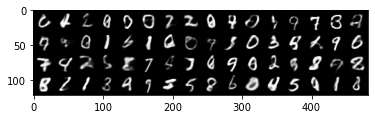

In [11]:
# Reconstruct images from random samples of the latent space 
model.to(device)
sample = torch.randn(64, nz).to(device)
sample = model.decode(sample).cpu()
sample = sample.view(-1, 1, 28, 28)
sample.shape
grid_img = make_grid(sample, nrow=16)
plt.imshow(grid_img.permute(1,2,0))


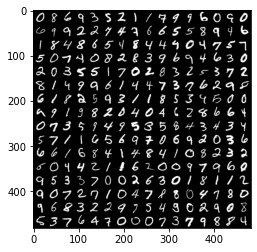

In [7]:
# compare original images and their reconstructions
originals, _ = iter(train_loader).next()
#originals.shape
grid_img = make_grid(originals, nrow=16)
plt.imshow(grid_img.permute(1,2,0))
# original:

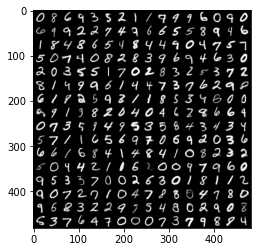

In [8]:
# and reconstruct:
model.to("cpu")
recons, _, __ = model(originals)
recons = recons.view(-1,1,28,28)
grid_img = make_grid(recons, nrow=16)
plt.imshow(grid_img.permute(1,2,0))




In [ ]:
#save_random_reconstructs(model, nz, 670)
#xs, _ = iter(train_loader).next()
#save_reconstructs(model, xs.to(device), 670)
#torch.save(model, "results/vae_mnist.pth")


# VAE for learning mixed models
We try to train a VAE on a simple mixeture distribution. In the first case, a mixture of 2 independent 5-dimensional diagonal gaussian rv. 
And the latent space is 2 dimensional.

The idea is to imbed nicely a high dimensional ($N$) data which is generated by a much lower number ($K << N$) of "signatures" (independent high-dimensional rvs) in 
a latent space of dimension ($M$) which is close to $K$, ($N >> M \geq K$)

In [41]:
nin = 5 # dimension of the data sapace
nk = 2 # number of indipendent distributions in the mixture
nz = 2 # the dimension of out latent space should be >= nk, I think...
batchSize = 128

# weights of the 'selection' distribution. Lets make one of the rv twice as likely as the other...
weights = torch.tensor([1,2])
mix = D.Categorical(weights)
#mix.batch_shape, mix.event_shape
#mix.sample().shape

compGauss = D.Independent(
        D.Normal(torch.rand(nk, nin), torch.rand(nk, nin)), 1)
gmm = D.MixtureSameFamily(mix, compGauss)
gmm.batch_shape, gmm.event_shape
gmm.sample().shape
gmm.sample((10,)).shape




torch.Size([10, 5])

In [43]:
# Define the model
model = VAE(nin, nz, 2024, 912, 912, 2024).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
TINY = 1e-12

mse = nn.MSELoss()


# training
numbatches = 3000
for batch in range(numbatches):
    # generate a batch-some of data
    x = gmm.sample((batchSize,)).to(device)
    #x = TINY/2 + (1 - TINY)*x 
    batch_size = x.shape[0]
    # x = data.view(-1,nin).to(device)
    model.train()
    model.requires_grad_(True)
    optimizer.zero_grad()
    recon, mu, logvar = model(x)
    #loss_recon = bce(recon + TINY, x)
    loss_recon = mse(recon + TINY, x)
    loss_kld = kld(mu + TINY, logvar)
    loss = loss_kld + loss_recon
    loss.backward()
    optimizer.step()
    
    if batch % 1000 == 0:
        print(
            "losses:\n",
            "reconstruction loss:",
            loss_recon.item(),
            "kld:",
            loss_kld.item(),
        )






losses:
 reconstruction loss: 0.4008323848247528 kld: 1.7250149250030518
losses:
 reconstruction loss: 0.37319907546043396 kld: 0.0003329813480377197
losses:
 reconstruction loss: 0.37817952036857605 kld: 0.0002282559871673584


In [46]:
# take 1000 sample each from the mixture distribution and some random normal distribution and compare the reconstruction loss:
test_real = gmm.sample((1000,)).to(device)
test_fake = torch.randn((1000,5)).to(device)
test_real.shape
test_fake.shape

recon_real, mu_real, logvar_real = model(test_real)
recon_fake, mu_fake, logvar_fake = model(test_fake)

print("recostruction loss for real: ",
      mse(recon_real, test_real).item(),
      "reconstruction loss for fake: ",
      mse(recon_fake, test_fake).item()
     )



## save model weights (needs to create model instance to load the weights)
#model.cpu()
#torch.save(model.state_dict(), "./results/vae_mix_2_5_gauss_weights.pth")
## load model weighte:
#model2 = VAE(nin, nz, 2024, 912, 912, 2024).to(device)
#model2.load_state_dict(torch.load("./results/vae_mix_2_5_gauss_weights.pth"))
## save the model itself with weights
#torch.save(model, "./results/vae_mix_2_5_gauss.pth")
## load model
#model3 = torch.load("results/vae_mix_2_5_gauss.pth")




recostruction loss for real:  0.35270801186561584 reconstruction loss for fake:  1.2719966173171997
